In [1]:
import numpy as np
from tqdm import tqdm
import scipy as sp
import scipy.stats as sps
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()
%matplotlib inline

## Считывание данных

In [2]:
import xml.etree.ElementTree as ET

In [3]:
features = ["BlackCount", "WhiteHolesCount", "HorzStrokesCount", "VertStrokesCount", "MaxHorzStrokeLength",
            "Left", "Right", "Top", "Bottom", "y"]
data = pd.DataFrame(columns=features)
curr_ind = 0
def read_folder(folder, y, curr_ind = 0):
    
    files = map(lambda x: folder + '/' + x, filter(lambda x: x.endswith('.xml'), os.listdir(folder)))
    for file in tqdm(files):
        root = ET.parse(file).getroot()
        for fragmentW, fragmentR in zip(root.iter('WordFragment'), root.iter('Rect')):
            if fragmentW.get("IsVertical") == True:
                continue
            arr = []
            for feature in features:
                if fragmentW.get(feature) is None:
                    arr.append(fragmentR.get(feature))
                else:
                    arr.append(fragmentW.get(feature))
            arr[-1] = y
            data.loc[curr_ind] = arr
            curr_ind += 1

In [4]:
read_folder("Text", 1, curr_ind = 0)

13it [06:46, 37.41s/it]


In [5]:
data.shape

(24935, 10)

In [6]:
read_folder("Nontext", 0, curr_ind = data.shape[0])

21it [11:17, 56.23s/it]


In [7]:
data.shape

(43009, 10)

In [8]:
for column in data.columns:
    data[column] = data[column].astype(float)

In [9]:
data["Window size"] = np.abs(data["Right"] - data["Left"]) * np.abs(data["Top"] - data["Bottom"])

In [10]:
data["Percentage of black"] = data["BlackCount"] / data["Window size"]

In [11]:
data["y"] = data["y"].astype(int)

## Адекватность данных (дупликаты)

In [12]:
data.shape

(43009, 12)

In [13]:
data.drop_duplicates(inplace = True)

In [14]:
data.shape

(33000, 12)

Как видим, очень много дупликатов в данных (это значит, что одна и та же арена картинки отмечена несколько раз)

Далее, уберем признаки Right, Left, Top, Bottom, так как на них модели могут переобучиться для данных изображений (не для отдельных частей картинки (для которых предсказываем текст/не текст) в тесте, а на всех изображений, находя ближайших соседей к данной части картинки  по этим признакам).

In [15]:
data.drop(columns = ["Left", "Right", "Top", "Bottom"], inplace = True)

## Выделение датасетов с текстом и без него

In [16]:
data_text = data[data["y"] == 1]
data_nontext = data[data["y"] == 0]

In [17]:
data_text.shape, data_nontext.shape

((22569, 8), (10431, 8))

## Выбросы


Найдем в каждом датасете 0.5% выбросов. Был взят IsolationForest, так как он один из лучших поисковиков аномалий.

In [18]:
from sklearn.ensemble import IsolationForest

/home/dimon2016/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [19]:
def rechange_ans(ypred):
    ypred[ypred == 1] = 0
    ypred[ypred == -1] = 1
    return ypred

In [20]:
iforest = IsolationForest(contamination=0.005, n_estimators=200).fit(data_text.drop(columns = ["y"]))
ypred_forest = iforest.predict(data_text.drop(columns = ["y"]))
ypred_forest = rechange_ans(ypred_forest)

/home/dimon2016/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [21]:
ypred_forest[ypred_forest == 1].size / ypred_forest.size

0.005006867827551066

Визуализируем результат с помощью TSNE.

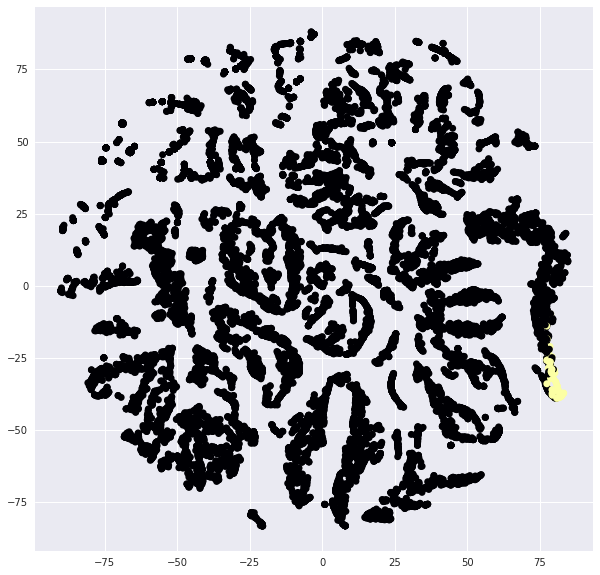

In [22]:
tsne = TSNE(n_components = 2, perplexity = 40)
Z = tsne.fit_transform(data_text.drop(columns = ["y"]))
plt.figure(figsize = (10, 10))
plt.scatter(Z[:, 0], Z[:, 1], c=ypred_forest, linewidths=0, cmap='inferno')
plt.show()

Как видим, аномалии кластеризованы в одной компоненте.

удалим выбросы для обучения.

In [23]:
data_text_new = data_text.drop(data_text.index[np.where(ypred_forest == 1)])

In [24]:
data_text_new.shape

(22456, 8)

Проделаем тоже самое для "не текста".

In [25]:
iforest = IsolationForest(contamination=0.005, n_estimators=200).fit(data_nontext.drop(columns = ["y"]))
ypred_forest = iforest.predict(data_nontext.drop(columns = ["y"]))
ypred_forest = rechange_ans(ypred_forest)

/home/dimon2016/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [26]:
ypred_forest[ypred_forest == 1].size / ypred_forest.size

0.005081008532259611

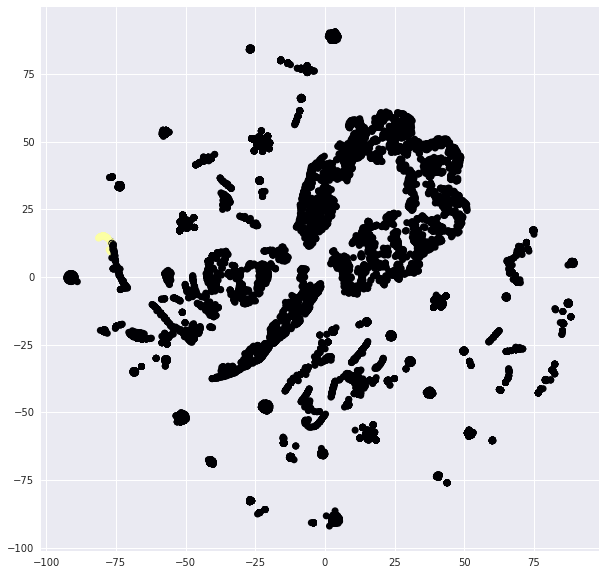

In [27]:
tsne = TSNE(n_components = 2, perplexity = 40)
Z = tsne.fit_transform(data_nontext.drop(columns = ["y"]))
plt.figure(figsize = (10, 10))
plt.scatter(Z[:, 0], Z[:, 1], c=ypred_forest, linewidths=0, cmap='inferno')
plt.show()

Аномалии снова сгруппированы.

In [28]:
data_nontext_new = data_nontext.drop(data_nontext.index[np.where(ypred_forest == 1)])

In [29]:
data_new = pd.concat([data_text_new, data_nontext_new])

In [30]:
data_new.shape

(32834, 8)

## Создадим train/test.

In [31]:
train_data, test_data, train_y, test_y = \
 train_test_split(data_new.drop(columns = ["y"]), data_new["y"], test_size=0.2, random_state = 42)

In [32]:
train_data.head()

,BlackCount,WhiteHolesCount,HorzStrokesCount,VertStrokesCount,MaxHorzStrokeLength,Window size,Percentage of black
14426,1152.0,3.0,226.0,160.0,22.0,3484.0,0.330654
832,288.0,0.0,54.0,44.0,20.0,858.0,0.335664
38723,205.0,0.0,108.0,78.0,3.0,2080.0,0.098558
40207,15.0,0.0,5.0,4.0,4.0,20.0,0.750000
13226,153.0,0.0,30.0,34.0,14.0,480.0,0.318750


In [33]:
test_data.head()

,BlackCount,WhiteHolesCount,HorzStrokesCount,VertStrokesCount,MaxHorzStrokeLength,Window size,Percentage of black
17783,5.0,0.0,2.0,3.0,3.0,6.0,0.833333
13047,139.0,0.0,32.0,20.0,11.0,456.0,0.304825
26174,10.0,0.0,3.0,6.0,6.0,18.0,0.555556
35299,8.0,0.0,5.0,5.0,2.0,25.0,0.320000
16595,218.0,2.0,30.0,33.0,15.0,304.0,0.717105


In [34]:
train_data.shape, test_data.shape

((26267, 7), (6567, 7))

In [35]:
np.mean(train_y), np.mean(test_y)

(0.6835573152624966, 0.6853966803715548)

## Метрики

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import scikitplot as skplt
import matplotlib.pyplot as plt

In [42]:
def show_results(test_y, ypred, ypred_proba):
    print('Accuracy: {:4f}'.format(accuracy_score(test_y, ypred)))
    print('Precision: {:4f}'.format(precision_score(test_y, ypred)))
    print('Recall: {:4f}'.format(recall_score(test_y, ypred)))
    print('AUC-ROC (for class text): {:4f}'.format(roc_auc_score(test_y, ypred_proba[:,1])))

    precision, recall, thresholds = precision_recall_curve(test_y, ypred_proba[:,1])
    print('AUC-PR (for class text): {:4f}'.format(auc(recall, precision)))
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    skplt.metrics.plot_roc(test_y, ypred_proba, \
                       title_fontsize = 20, text_fontsize = 10, ax = axes[0])
    skplt.metrics.plot_precision_recall(test_y, ypred_proba, \
                    title_fontsize = 20, text_fontsize = 10, ax = axes[1])
    plt.show()

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params =  {'n_estimators': [500, 700, 1000]}

model = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring='roc_auc', n_jobs=-1)
model.fit(train_data, train_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500, 700, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [39]:
best_mod = model.best_estimator_
print('Best params: {}'.format(model.best_params_))
print('Best AUC-ROC: {:4f}'.format(model.best_score_))

Best params: {'n_estimators': 1000}
Best AUC-ROC: 0.964051


In [40]:
best_mod.fit(train_data, train_y)
ypredtree = model.predict(test_data)
ypred_probatree = model.predict_proba(test_data)


Accuracy: 0.912746
Precision: 0.942542
Recall: 0.929349
AUC-ROC (for class text): 0.966591
AUC-PR (for class text): 0.985305


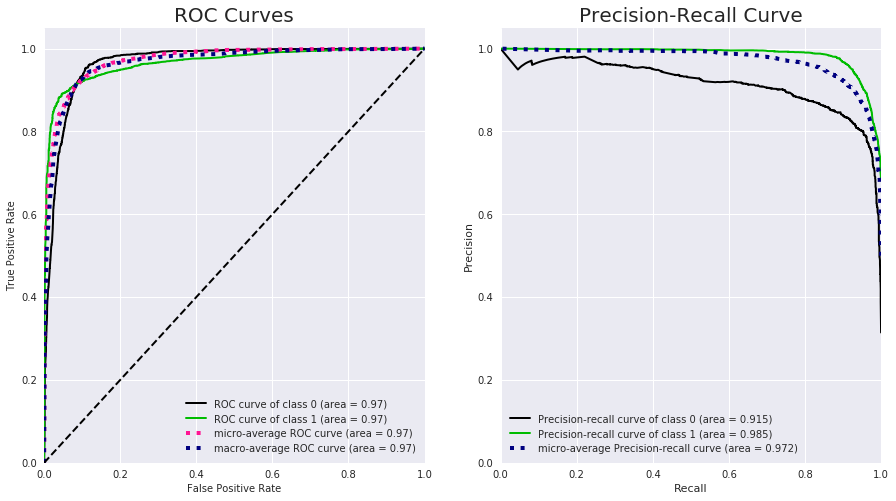

In [43]:
show_results(test_y, ypredtree, ypred_probatree)

Достаточно хороший скор, но попробуем взять более усоверженствованную модель.

## XGBOOST

по хорошему, стоило бы отнормировать данные, но и без этого хорошо работает...

In [44]:
gc.collect()

5660

In [45]:
import xgboost as xgb

params = {'n_estimators': [500, 700],
          'learning_rate': [0.1, 0.001],
          'max_depth': [5, 7]}

model = GridSearchCV(xgb.XGBClassifier(), params, cv=3, scoring='roc_auc')
model.fit(train_data, train_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500, 700], 'learning_rate': [0.1, 0.001], 'max_depth': [5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [46]:
best_mod = model.best_estimator_
print('Best params: {}'.format(model.best_params_))
print('Best AUC-ROC: {:4f}'.format(model.best_score_))

Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700}
Best AUC-ROC: 0.965157


In [47]:
best_mod.fit(train_data, train_y)
ypredxgb = model.predict(test_data)
ypred_probaxgb = model.predict_proba(test_data)


/home/dimon2016/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.918532
Precision: 0.949660
Recall: 0.930460
AUC-ROC (for class text): 0.968077
AUC-PR (for class text): 0.985501


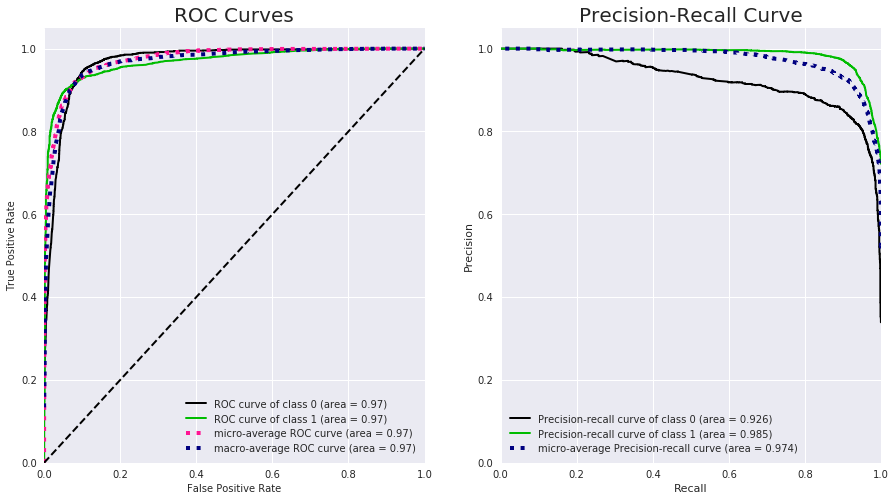

In [48]:
show_results(test_y, ypredxgb, ypred_probaxgb)

Как видим, наилучший скор на тесте - 0.990494 для AUC-ROC и 0.995658 для AUC-PR. Результат был получен с помощью XGBoost.

## Сравние моделей

Сначала вычислим ошибки (для вероятностей, конечно же).

In [49]:
e_xgb =  [pred[1 - y] for y, pred in zip(test_y, ypred_probaxgb)]
e_tree = [pred[1 - y] for y, pred in zip(test_y, ypred_probatree)]

Построим распределение ошибок.

/home/dimon2016/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


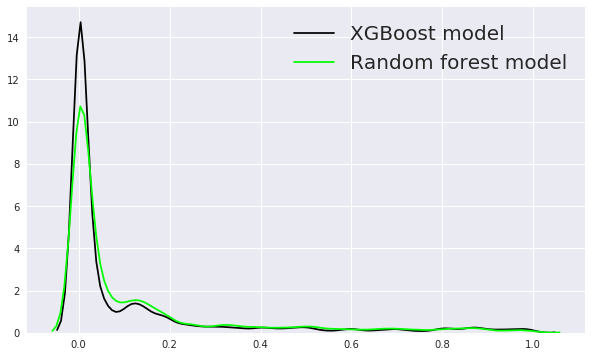

In [50]:
plt.figure(figsize = (10, 6))
sns.distplot(e_xgb, hist = False, color = 'black', label = "XGBoost model")
sns.distplot(e_tree, hist = False, color = 'lime', label = "Random forest model")
plt.legend(fontsize = 20)
plt.show()

Воспользуемся критерием знаков, чтобы узнать, произошло ли статистически улучшение результата. (Берем критерий знаков, так как выборки зависимы (предсказываем на одних и тех же данных)) (Из курса практической мат.статистики)

[ссылка на критерий, съезд VI.b](https://mipt-stats.gitlab.io/jekyll/update/2019/02/07/asda.html)

Что проверяет: 

$X_1,\ ...,\ X_n\ и\ Y_1,\ ...,\ Y_n$ - связные выборки

$Z_i = Y_i - X_i = \theta + \epsilon_i$

$H_0:\ \theta\ =\ 0\ vs.\ H_1:\ \theta > 0$

In [51]:
def create_signed_test(x, y):
    z = x - y
    z = np.array(z)
    s = np.sum(z > 0)
    n = z.shape[0]
    stat = (s - n / 2 - 1 / 2) / np.sqrt(n / 4)
    ans = sps.norm.sf(stat)
    return ans

In [52]:
create_signed_test(np.array(e_tree), np.array(e_xgb))

3.373841002089702e-20

Как видно, статистически улучшение получилось значимым (Значение p-value критерия практически 0, а значит произошло отвержение $H_0$ в пользу $H_1$, то есть улучшение статистически значимо). А значит стоит использовать модель XGBoost.

## Анализ ошибок XGBoost

Судя по гистограмме, ошибки из эекспоненчиального распределения или из Парето. Попробуем промоделировать их с помощью экспоненциального с параметром $\lambda\ =\ \dfrac{1}{\overline{X}}$  (ОМП для экспоненциального). Для Парето - доверим Питону.

In [216]:
e_xgb = np.array(e_xgb)
N = e_xgb.shape[0]

In [224]:
from scipy import stats, optimize
rvs = e_xgb
rvsmin = rvs.min() #for starting value to fmin
est = stats.pareto.fit(rvs)

/home/dimon2016/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [226]:
est

(2.0066822025987108, -0.04630007459957805, 0.046302003805840236)

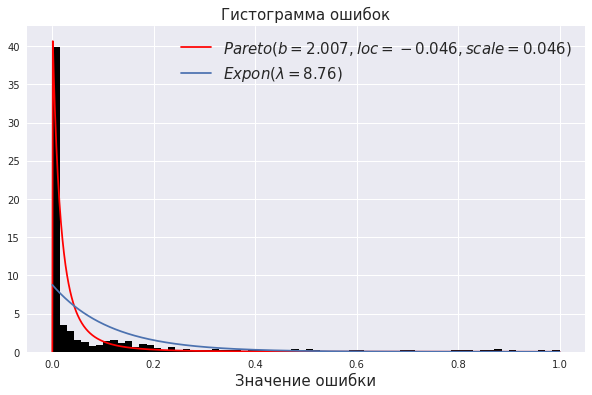

In [229]:
grid = np.linspace(0, 1, 1000)
plt.figure(figsize = (10, 6))
plt.title("Гистограмма ошибок", fontsize = 15)
plt.hist(e_xgb, bins = 70, normed = True, color = 'black')
plt.plot(grid, sps.pareto(est[0], est[1], est[2]).pdf(grid), color = "r", \
        label = "$Pareto(b = {}, loc = {}, scale = {})$".format(\
                np.round(est[0], 3), np.round(est[1], 3), \
                np.round(est[2], 3)))
plt.plot(grid, sps.expon(scale =  np.mean(e_xgb)).pdf(grid), \
         label = "$Expon(\\lambda = {})$".format(np.round(1 / np.mean(e_xgb), 3)))
plt.xlabel("Значение ошибки", fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

Проверим статистически с помощью критерия Колмогорова-Смирнова, является ли данное приближение адекватным.

In [220]:
sps.kstest(e_xgb, sps.expon(scale = np.mean(e_xgb)).cdf)

KstestResult(statistic=0.45665340460024584, pvalue=0.0)

In [221]:
sps.kstest(e_xgb, sps.pareto(est[0], est[1], est[2]).cdf)

KstestResult(statistic=0.2990423355532722, pvalue=0.0)

Как видим, гипотеза о том, что распределение ошибок из экспоненциального распределения (с параметром, подобранным из ОМП) или из Парето, отверглась. Хотя, при этом, безусловно, Парето приближает лучше, поэтому, в крайнем случае, ошибки бы я приближал с его помощью.

Возможно, стоило бы использовать Zero-inflated распределения (отделив каким то маленьким порогом все значения близ 0, и сделать из них 0), но адекватных вариантов я реализовать не смог. 

## Результаты.

В итоге, мы получили отличный скор на тесте, доказали, что XGBoost в данном случае, лучше чем RandomForest, проанализировали ошибки (хоть и не смогли найти, из какого они распределения, но визуально Парето может сгодиться).